# Laboratorio 7
## 1) Image deblur
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:
$$ y = Ax + \eta $$
dove :
+ $y$ rappresenta l’immagine corrotta,
+ $x$ rappresenta l’immagine originale che vogliamo ricostruire
+ $A$ rappresenta l’operatore che applica il blur Gaussiano
+ $\eta \sim \mathcal{N}(0, \sigma^2)$ rappresenta una realizzazione di rumore additivo con distribuzione Gaussiana di media $\mu = 0$ e deviazione standard $\sigma$.

### Esercizio 1:
+ Caricare l’immagine camera dal modulo `skimage.data` rinormalizzandola nel range $[0, 1]$.
+ Applicare un blur di tipo gaussiano con deviazione standard 3 il cui kernel ha dimensioni 24 × 24. Utilizzare prima `cv2` (`open-cv`) e poi la trasformata di Fourier.
+ Aggiungere rumore di tipo gaussiano, con $\sigma = 0.02$, usando la funzione `np.random.normal()`.
+ Calcolare le metriche Peak Signal Noise Ratio (PSNR) e Mean Squared Error (MSE) tra l’immagine degradata e l’immagine esatta usando le funzioni `peak_signal_noise_ratio` e `mean_squared_error` disponibili nel modulo `skimage.metrics`.

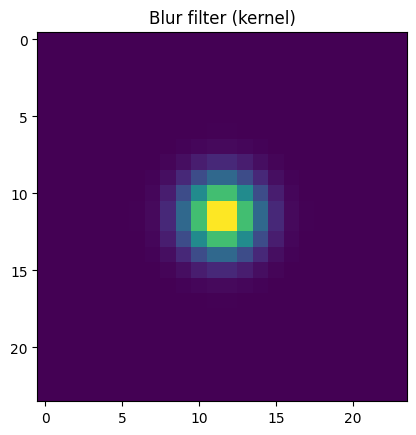

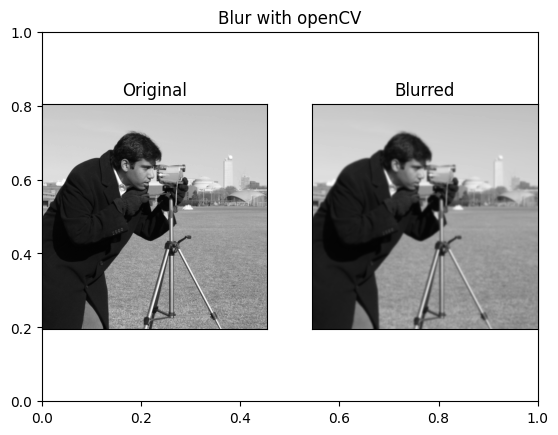

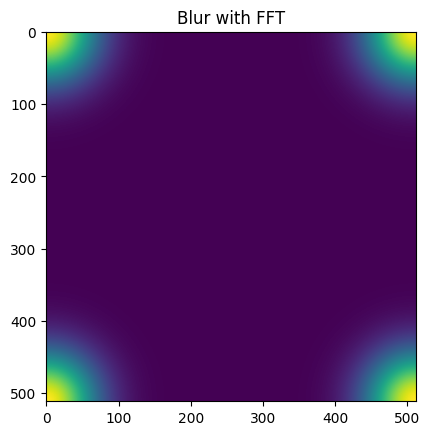

PSNR: 25.29 dB
MSE: 3.0e-03


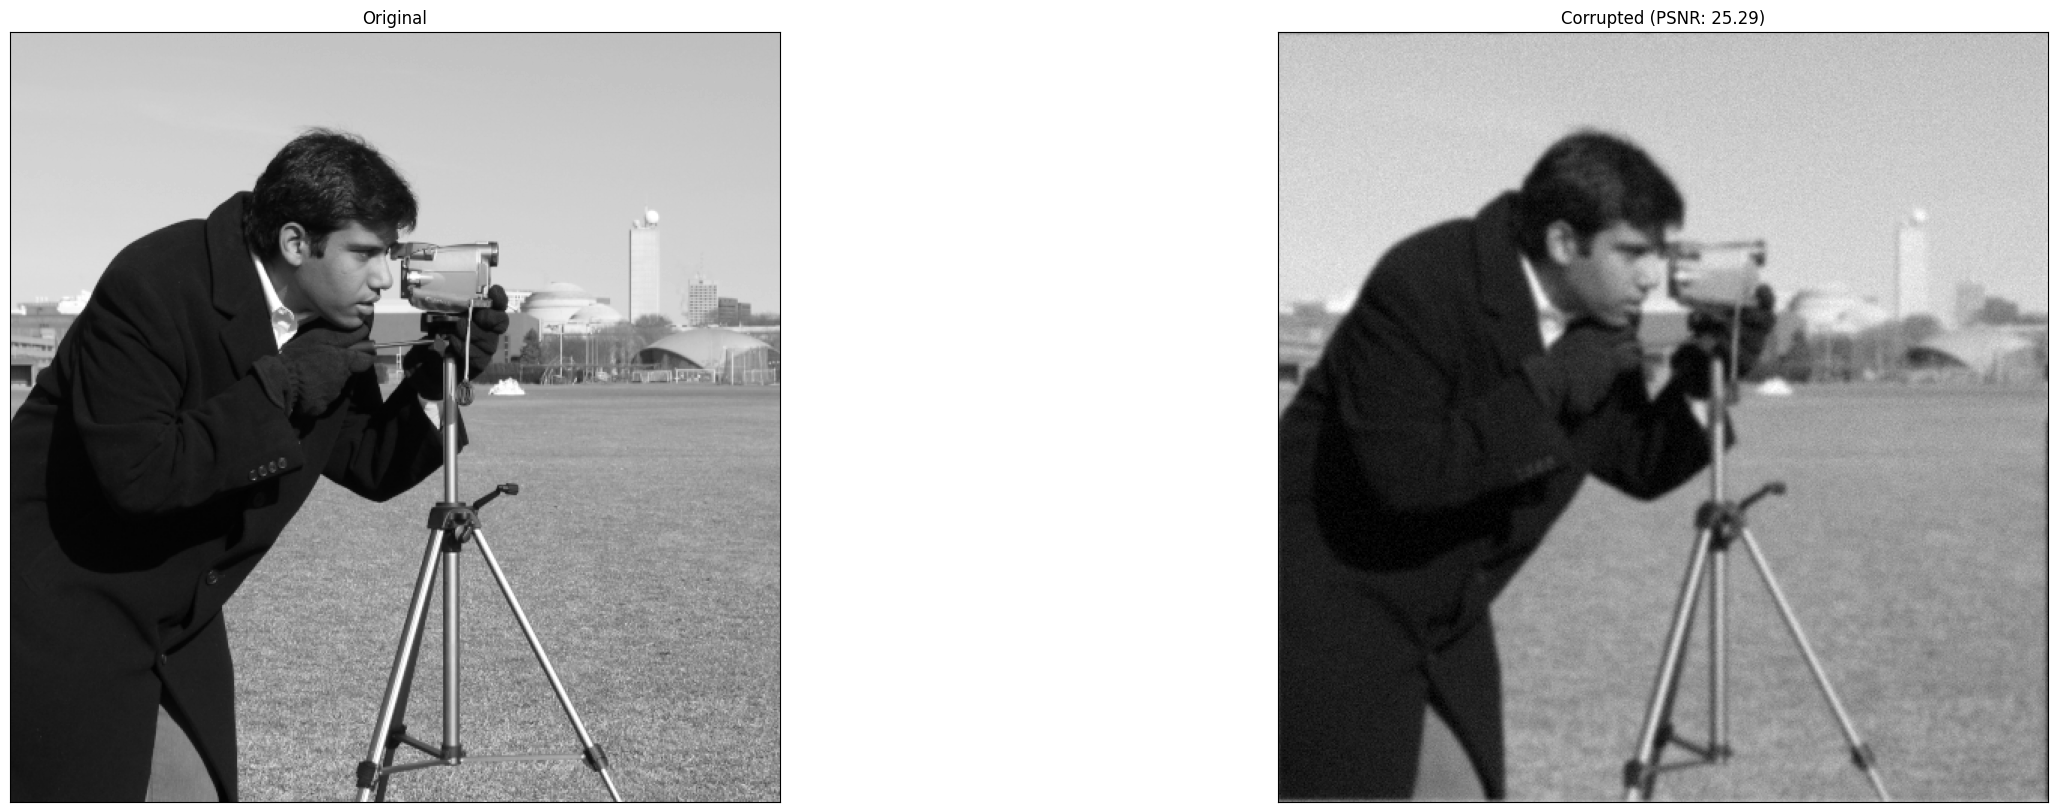

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from lib.utils import psf_fft, A, AT, gaussian_kernel

# Immagine in floating point con valori tra 0 e 1
X = data.camera().astype(float) / 255
m, n = X.shape

# Genera il filtro di blur
k = gaussian_kernel(24, 3)
plt.imshow(k)
plt.title('Blur filter (kernel)')
plt.show()

# Blur with openCV
X_blurred = cv.filter2D(X, -1, k)
plt.figure()
plt.title('Blur with openCV')
plt.subplot(1,2,1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

# Blur with FFT
K = psf_fft(k, 24, (m, n))
plt.imshow(np.abs(K))
plt.title('Blur with FFT')
plt.show()

X_blurred = A(X, K)

# Genera il rumore
sigma = 0.02
np.random.seed(42)
noise = np.random.normal(size=X.shape) * sigma

# Aggiungi blur e rumore
y = X_blurred + noise
PSNR = metrics.peak_signal_noise_ratio(X, y)
MSE = metrics.mean_squared_error(X, y)
print(f'PSNR: {PSNR:.2f} dB')
print(f'MSE: {MSE:.1e}')
ATy = AT(y, K)


# Visualizziamo i risultati
plt.figure(figsize=(30, 10))
plt.subplot(1,2,1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

### Esercizio 2: soluzione naive
Una possibile ricostruzione dell’immagine originale $x$ partendo dall’immagine corrotta $y$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
$$ x^\ast = \arg \min_{x} \dfrac{1}{2} {\|Ax − y\|}^2_2 $$
+ Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` della libreria `scipy`, calcolare la soluzione naive.
+ Analizza l’andamento del PSNR e dell’MSE al variare del numero di iterazioni.

(262144,)
(512, 512)


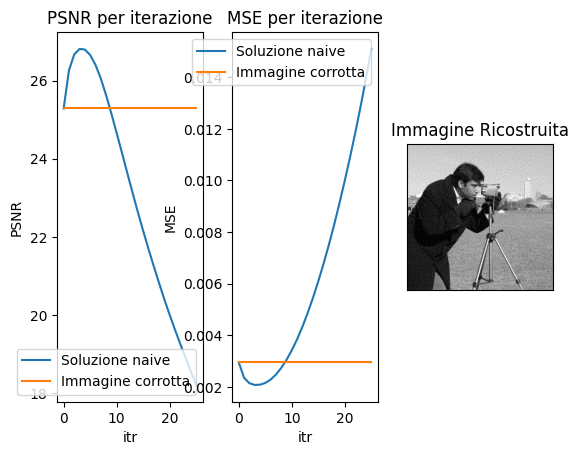

In [5]:
from scipy.optimize import minimize

# Funzione da minimizzare
def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))

# Gradiente della funzione da minimizzare
def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n)

# Minimizzazione della funzione
x0 = y.reshape(m*n)
print(x0.shape)
print(y.shape)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter, 'return_all':True})

# Per ogni iterazione calcola PSNR e MSE rispetto all'originale
PSNR = np.zeros(max_iter + 1)
MSE = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))
    MSE[k] = metrics.mean_squared_error(X, x_k.reshape(X.shape))

# Risultato della minimizzazione
X_res = res.x.reshape((m, n))

# PSNR dell'immagine corrotta rispetto all'oginale
starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_MSE = np.full(MSE.shape[0], metrics.mean_squared_error(X, y))

# Visualizziamo i risultati
ax2 = plt.subplot(1, 3, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('itr')
ax3 = plt.subplot(1, 3, 2)
ax3.plot(MSE, label="Soluzione naive")
ax3.plot(starting_MSE, label="Immagine corrotta")
plt.legend()
plt.title('MSE per iterazione')
plt.ylabel("MSE")
plt.xlabel('itr')
plt.subplot(1, 3, 3).imshow(X_res, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Ricostruita')
plt.xticks([]), plt.yticks([])
plt.show()

### Esercizio 3: soluzione regolarizzata
Si consideri il seguente problema regolarizzato secondo Tikhonov:
$$ x^\ast = \arg \min_{x} \dfrac{1}{2} {\|Ax − y\|}^2_2 + \lambda {\|x\|}^2_2 $$
+ Utilizzando sia il metodo del gradiente che il metodo del gradiente coniugato calcolare la soluzione del problema regolarizzato.
+ Analizzare l’andamento del PSNR e dell’MSE al variare del numero di iterazioni.
+ Facendo variare il parametro di regolarizzazione $\lambda$, analizzare come questo influenza le prestazioni del metodo analizzando le immagini.
+ Scegliere $\lambda$ con il metodo di discrepanza.
+ Scegliere $\lambda$ attraverso test sperimentali come il valore che massimizza il valore del PSNR. Confrontare il valore ottenuto con quella della massima discrepanza.

0.01
PSNR: 26.26 (λ = 0.01)
MSE: 2.4e-03 (λ = 0.01)
0.03
PSNR: 26.86 (λ = 0.03)
MSE: 2.1e-03 (λ = 0.03)
0.04
PSNR: 26.47 (λ = 0.04)
MSE: 2.3e-03 (λ = 0.04)
0.06
PSNR: 25.42 (λ = 0.06)
MSE: 2.9e-03 (λ = 0.06)


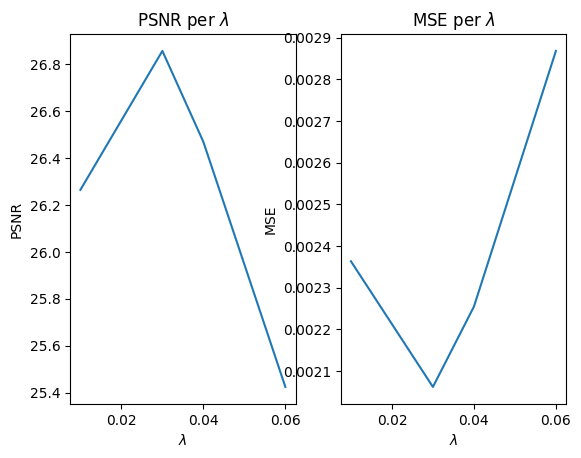

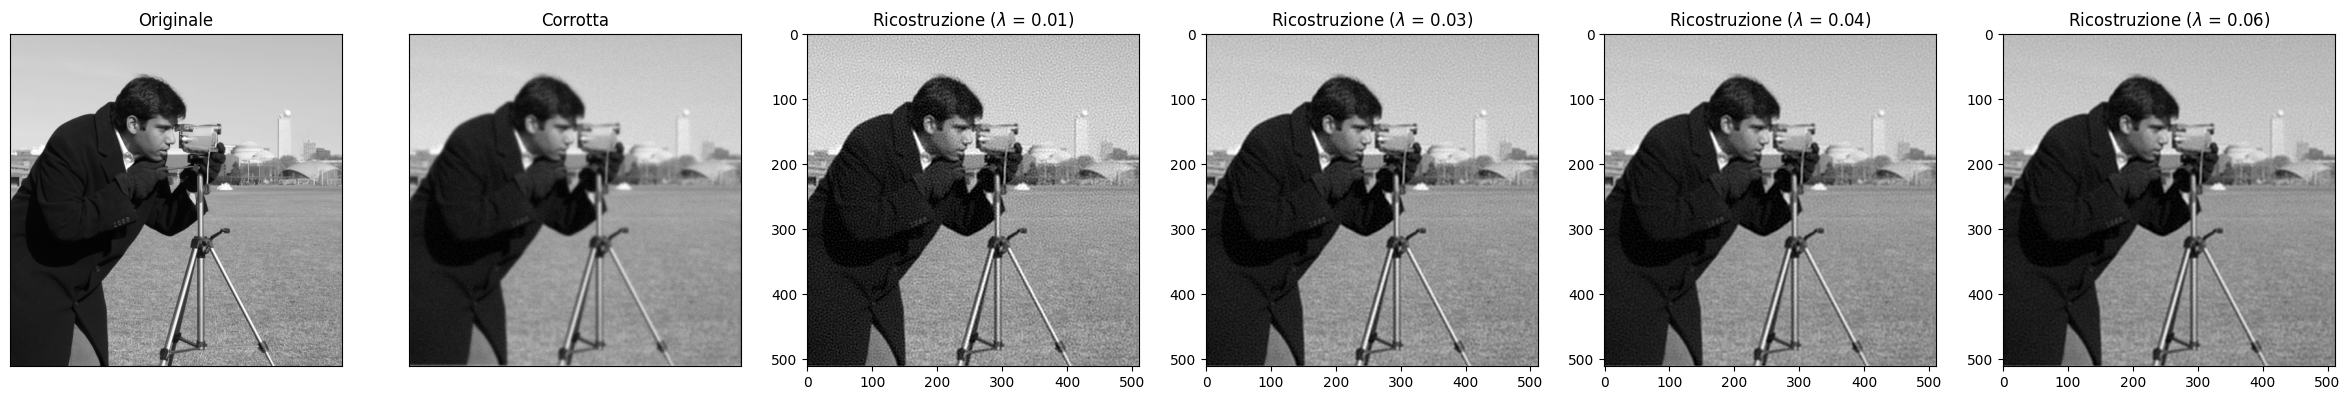

In [6]:
import scipy


# Funzione da minimizzare
def f(x, L):
    nsq = np.sum(np.square(x))
    x  = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq

# Gradiente della funzione da minimizzare
def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

x0 = y.reshape(m*n)
lambdas = [0.01,0.03,0.04, 0.06]
PSNRs = []
MSEs = []
images = []

# Ricostruzione per diversi valori del parametro di regolarizzazione
for i, L in enumerate(lambdas):
    # Esegui la minimizzazione con al massimo 50 iterazioni
    max_iter = 50
    print(L)
    res = scipy.optimize.minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})

    # Aggiungi la ricostruzione nella lista images
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)

    # Stampa il PSNR per il valore di lambda attuale
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    MSE = metrics.mean_squared_error(X, X_curr)
    MSEs.append(MSE)
    print(f'PSNR: {PSNR:.2f} (\u03BB = {L:.2f})')
    print(f'MSE: {MSE:.1e} (\u03BB = {L:.2f})')
    
    

# Visualizziamo i risultati
plt.subplot(1, 2, 1)
plt.plot(lambdas,PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.subplot(1, 2, 2)
plt.plot(lambdas,MSEs)
plt.title('MSE per $\lambda$')
plt.ylabel("MSE")
plt.xlabel('$\lambda$')
plt.show()

plt.figure(figsize=(30, 10))

plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])


for i, L in enumerate(lambdas):
  plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
  plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
plt.show()